In [2]:
# /*==========================================================================================*\
# **                        _           _ _   _     _  _         _                            **
# **                       | |__  _   _/ | |_| |__ | || |  _ __ | |__                         **
# **                       | '_ \| | | | | __| '_ \| || |_| '_ \| '_ \                        **
# **                       | |_) | |_| | | |_| | | |__   _| | | | | | |                       **
# **                       |_.__/ \__,_|_|\__|_| |_|  |_| |_| |_|_| |_|                       **
# \*==========================================================================================*/


# -----------------------------------------------------------------------------------------------
# Author: Bùi Tiến Thành - Tien-Thanh Bui (@bu1th4nh)
# Title: OV.ipynb
# Date: 2025/01/23 17:33:25
# Description: Preprocessing and Exploratory Data Analysis for the OV dataset
# 
# (c) 2025 bu1th4nh. All rights reserved. 
# Written with dedication in the University of Central Florida, EPCOT and the Magic Kingdom.
# -----------------------------------------------------------------------------------------------



import s3fs
import logging
import numpy as np
import pandas as pd
from tqdm import tqdm
from typing import List, Dict, Any, Tuple, Union, Literal
import ydata_profiling as ydp
import matplotlib.pyplot as plt
import os



# DATA_PATH = '/home/ti514716/Datasets/OvarianCancer'
# storage_options = None
# s3 = None

TEST_PASS = 100
OVERRIDE_EXISTING_2_OMICS = False
OVERRIDE_EXISTING_3_OMICS = True




DATA_PATH = 's3://datasets/OvarianCancer'
storage_options = {
    'key': 'bu1th4nh',
    'secret': 'ariel.anna.elsa',
    'endpoint_url': 'http://localhost:9000',
}
s3 = s3fs.S3FileSystem(
    key=storage_options['key'],
    secret=storage_options['secret'],
    endpoint_url=storage_options['endpoint_url'],
    use_ssl=False,
)

/home/ti514716/Venvs/CrossOmics/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# Parquet-ize the data
parquetize = False
if s3 is not None:
    if not s3.exists(f'{DATA_PATH}/raw_parquet'):
        s3.makedirs(f'{DATA_PATH}/raw_parquet')
        parquetize = True
else:
    if not os.path.exists(f'{DATA_PATH}/raw_parquet'):
        os.makedirs(f'{DATA_PATH}/raw_parquet')
        parquetize = True


if parquetize:
    pd.read_csv(f'{DATA_PATH}/raw_textfiles/bipartite_targetscan_gene.csv', storage_options=storage_options).to_parquet(f'{DATA_PATH}/raw_parquet/bipartite_targetscan_gene.parquet', storage_options=storage_options)
    pd.read_csv(f'{DATA_PATH}/raw_textfiles/ov_tcga_pan_can_atlas_2018_clinical_data.tsv', sep='\t', storage_options=storage_options).to_parquet(f'{DATA_PATH}/raw_parquet/ov_clinical.parquet', storage_options=storage_options)
    pd.read_csv(f'{DATA_PATH}/raw_textfiles/DNAMethyl_OV_27k', sep='\t', storage_options=storage_options).to_parquet(f'{DATA_PATH}/raw_parquet/methDNA.parquet', storage_options=storage_options)
    pd.read_csv(f'{DATA_PATH}/raw_textfiles/miRNA_HiSeq_gene', sep='\t', storage_options=storage_options).to_parquet(f'{DATA_PATH}/raw_parquet/miRNA.parquet', storage_options=storage_options)
    pd.read_csv(f'{DATA_PATH}/raw_textfiles/mRNA_HiSeqV2', sep='\t', storage_options=storage_options).to_parquet(f'{DATA_PATH}/raw_parquet/mRNA.parquet', storage_options=storage_options)


# Data Acquisition

In [3]:
raw_bipart_data = pd.read_parquet(f'{DATA_PATH}/raw_parquet/bipartite_targetscan_gene.parquet', storage_options=storage_options)
raw_clinical = pd.read_parquet(f'{DATA_PATH}/raw_parquet/ov_clinical.parquet', storage_options=storage_options)
raw_methDNA = pd.read_parquet(f'{DATA_PATH}/raw_parquet/methDNA.parquet', storage_options=storage_options)
raw_miRNA = pd.read_parquet(f'{DATA_PATH}/raw_parquet/miRNA.parquet', storage_options=storage_options)
raw_mRNA = pd.read_parquet(f'{DATA_PATH}/raw_parquet/mRNA.parquet', storage_options=storage_options)

# Elementary Data Analysis

### mRNA, miRNA, and methylation data

In [4]:
# Sampling
display(raw_mRNA.head())
display(raw_miRNA.head())
display(raw_methDNA.head())

,sample,TCGA-61-1910-01,TCGA-61-1728-01,TCGA-09-1666-01,TCGA-24-1469-01,TCGA-04-1348-01,TCGA-61-1917-01,TCGA-61-2009-01,TCGA-31-1950-01,TCGA-31-1951-01,...,TCGA-24-1560-01,TCGA-29-1783-01,TCGA-59-2348-01,TCGA-24-1424-01,TCGA-13-1507-01,TCGA-25-2404-01,TCGA-61-2095-01,TCGA-29-1702-01,TCGA-24-1417-01,TCGA-57-1585-01
0,ARHGEF10L,9.6011,9.3203,8.1951,8.5826,8.7195,8.0901,8.6452,9.8853,10.1132,...,6.1288,9.6335,9.9237,8.9389,8.6923,9.2133,10.2494,8.1640,8.6072,10.0930
1,HIF3A,3.2786,7.3655,5.6778,9.6524,9.9184,11.2161,9.6066,8.7037,8.8622,...,8.0357,10.9582,2.7875,10.0217,5.5355,7.1770,10.0390,10.9421,9.0313,8.9991
2,RNF17,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.4621,...,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.8216,0.0000,0.0000,0.0000
3,RNF10,12.4351,11.8492,11.0238,11.4436,12.1362,11.1611,11.9031,12.1210,12.1182,...,12.8924,11.6807,12.5429,12.2612,10.6557,12.0531,11.8931,11.1066,11.7897,11.6380
4,RNF11,10.1028,10.7862,11.3112,10.4607,10.2388,10.8223,11.1603,10.6347,10.7654,...,11.8616,11.5198,11.1295,10.6540,11.3689,10.7873,10.7397,11.2760,11.0385,10.8238


,sample,TCGA-61-1910-01,TCGA-61-1728-01,TCGA-31-1953-01,TCGA-31-1951-01,TCGA-24-1552-01,TCGA-13-1477-01,TCGA-30-1862-01,TCGA-29-1698-01,TCGA-13-0924-01,...,TCGA-23-2078-01,TCGA-13-0891-01,TCGA-24-2289-01,TCGA-13-1481-01,TCGA-13-0761-01,TCGA-24-1545-01,TCGA-61-1907-01,TCGA-04-1638-01,TCGA-23-1118-01,TCGA-13-0723-01
0,MIMAT0019868,0.552600,NaN,0.330600,NaN,NaN,1.409282,0.972458,NaN,NaN,...,NaN,NaN,NaN,0.691031,NaN,NaN,1.952727,1.006519,0.7392,NaN
1,MIMAT0019869,NaN,NaN,NaN,0.6873,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,0.157900,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,MIMAT0019860,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,MIMAT0019862,0.128700,NaN,0.825971,NaN,NaN,NaN,0.401300,0.3751,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,0.442415,0.265200,0.7392,NaN
4,MIMAT0019864,0.725257,0.9217,0.330600,0.3842,0.463,NaN,0.401300,NaN,NaN,...,0.5532,NaN,0.429817,0.386500,0.563,NaN,NaN,0.682995,NaN,NaN


,sample,TCGA-61-1910-01,TCGA-61-1728-01,TCGA-72-4238-01,TCGA-13-1819-02,TCGA-31-1953-01,TCGA-13-1819-01,TCGA-25-2392-01,TCGA-31-1951-01,TCGA-24-1552-01,...,TCGA-61-1916-02,TCGA-13-0761-01,TCGA-24-1545-01,TCGA-10-0935-01,TCGA-01-0633-11,TCGA-04-1638-01,TCGA-23-1118-01,TCGA-13-1479-01,TCGA-36-2547-01,TCGA-13-0723-01
0,cg00000292,0.8414,0.9466,0.7846,0.7734,0.7804,0.8053,0.8874,0.8978,0.8990,...,0.8070,0.9120,0.8506,0.8021,0.8675,0.6975,0.9012,0.9470,0.8258,0.7648
1,cg00002426,0.0384,0.1052,0.1157,0.7666,0.0808,0.3654,0.2355,0.0806,0.0202,...,0.1802,0.1383,0.2008,0.0380,0.2057,0.0258,0.0863,0.5834,0.1884,0.2807
2,cg00003994,0.0817,0.0601,0.0554,0.0284,0.0303,0.0438,0.0418,0.7448,0.0235,...,0.0422,0.0933,0.0182,0.6720,0.0327,0.0453,0.0363,0.0494,0.0450,0.0637
3,cg00005847,0.0443,0.4241,0.7966,0.1780,0.6370,0.5863,0.8103,0.3585,0.0579,...,0.6025,0.7453,0.2712,0.4855,0.4610,0.9007,0.5696,0.1223,0.6160,0.2648
4,cg00006414,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [4]:
# Shape
print(f'mRNA shape: {raw_mRNA.shape[0]} rows and {raw_mRNA.shape[1]} columns')
print(f'miRNA shape: {raw_miRNA.shape[0]} rows and {raw_miRNA.shape[1]} columns')
print(f'methDNA shape: {raw_methDNA.shape[0]} rows and {raw_methDNA.shape[1]} columns')

mRNA shape: 20530 rows and 309 columns
miRNA shape: 2165 rows and 486 columns
methDNA shape: 27578 rows and 617 columns


In [6]:
# Columns
print(f'mRNA columns: {len(raw_mRNA.columns)}  :  {list(raw_mRNA.columns)}')
print(f'miRNA columns: {len(raw_miRNA.columns)}  :  {list(raw_miRNA.columns)}')
print(f'methDNA columns: {len(raw_methDNA.columns)}  :  {list(raw_methDNA.columns)}')
print()
# Sample Intersection
Ariel = set(raw_mRNA.columns) & set(raw_miRNA.columns) & set(raw_methDNA.columns)
print(f'Intersection all  {len(Ariel)}  :  {Ariel}')
print()
Ariel = set(raw_mRNA.columns) & set(raw_miRNA.columns)
print(f'Intersection mRNA and miRNA  {len(Ariel)}  :  {Ariel}')
Ariel = set(raw_mRNA.columns) & set(raw_methDNA.columns)
print(f'Intersection mRNA and methDNA  {len(Ariel)}  :  {Ariel}')
Ariel = set(raw_miRNA.columns) & set(raw_methDNA.columns)
print(f'Intersection miRNA and methDNA  {len(Ariel)}  :  {Ariel}')


# Sample Difference
Ariel = set(raw_mRNA.columns) - set(raw_miRNA.columns)
print(f'Sample Difference mRNA and miRNA  {len(Ariel)}  :  {Ariel}')
Ariel = set(raw_miRNA.columns) - set(raw_mRNA.columns)
print(f'Sample Difference miRNA and mRNA  {len(Ariel)}  :  {Ariel}')

Ariel = set(raw_methDNA.columns) - set(raw_miRNA.columns)
print(f'Sample Difference methDNA and miRNA  {len(Ariel)}  :  {Ariel}')
Ariel = set(raw_miRNA.columns) - set(raw_methDNA.columns)
print(f'Sample Difference miRNA and methDNA  {len(Ariel)}  :  {Ariel}')

Ariel = set(raw_methDNA.columns) - set(raw_mRNA.columns)
print(f'Sample Difference methDNA and mRNA  {len(Ariel)}  :  {Ariel}')
Ariel = set(raw_mRNA.columns) - set(raw_methDNA.columns)
print(f'Sample Difference mRNA and methDNA  {len(Ariel)}  :  {Ariel}')


mRNA columns: 309  :  ['sample', 'TCGA-61-1910-01', 'TCGA-61-1728-01', 'TCGA-09-1666-01', 'TCGA-24-1469-01', 'TCGA-04-1348-01', 'TCGA-61-1917-01', 'TCGA-61-2009-01', 'TCGA-31-1950-01', 'TCGA-31-1951-01', 'TCGA-61-1995-01', 'TCGA-24-2297-01', 'TCGA-24-1555-01', 'TCGA-25-1322-01', 'TCGA-24-1427-01', 'TCGA-29-1698-01', 'TCGA-23-1023-01', 'TCGA-13-0924-01', 'TCGA-24-1847-01', 'TCGA-24-1843-01', 'TCGA-25-1321-01', 'TCGA-30-1891-01', 'TCGA-25-1326-01', 'TCGA-29-2414-01', 'TCGA-09-1670-01', 'TCGA-24-2033-01', 'TCGA-29-2414-02', 'TCGA-61-1741-01', 'TCGA-31-1953-01', 'TCGA-30-1855-01', 'TCGA-25-1324-01', 'TCGA-09-2056-01', 'TCGA-29-1701-01', 'TCGA-25-1633-01', 'TCGA-25-2396-01', 'TCGA-61-1914-01', 'TCGA-61-2094-01', 'TCGA-29-1705-01', 'TCGA-36-1580-01', 'TCGA-25-2401-01', 'TCGA-5X-AA5U-01', 'TCGA-13-0916-01', 'TCGA-23-2084-01', 'TCGA-36-1577-01', 'TCGA-24-1551-01', 'TCGA-61-1998-01', 'TCGA-20-1684-01', 'TCGA-24-1556-01', 'TCGA-57-1582-01', 'TCGA-04-1362-01', 'TCGA-61-2113-01', 'TCGA-24-1924-01'

In [7]:
# 1st columns - mRNA/miRNA value
# Why 'sample'? Because of Pandas' read_csv mechanism. It is not very intuitive, but it is what it is.
mRNA_for_genes = raw_mRNA['sample']
miRNA_for_genes = raw_miRNA['sample']
methDNA_for_genes = raw_methDNA['sample']

print(f'mRNAs: {len(mRNA_for_genes)} :  {list(mRNA_for_genes)}')
print(f'miRNAs: {len(miRNA_for_genes)} :  {list(miRNA_for_genes)}')
print(f'methDNAs: {len(methDNA_for_genes)} :  {list(methDNA_for_genes)[:100]}')

mRNAs: 20530 :  ['ARHGEF10L', 'HIF3A', 'RNF17', 'RNF10', 'RNF11', 'RNF13', 'GTF2IP1', 'REM1', 'MTVR2', 'RTN4RL2', 'C16orf13', 'C16orf11', 'FGFR1OP2', 'TSKS', 'ATRX', 'PMM2', 'LOC100272146', 'ASS1', 'NCBP1', 'ZNF709', 'ZNF708', 'RBM14', 'NCBP2', 'DISC1', 'CAMK1', 'RPL37', 'SPR', 'ZNF700', 'ZNF707', 'CAMK4', 'ZNF704', 'LOC339240', 'GOLGA6B', 'RNF115', 'RNF112', 'ZC3H14', 'SPN', 'HMGCLL1', 'NACAP1', 'LRRTM1', 'GRIN1', 'RBMY1A3P', 'DHX8', 'DHX9', 'LOC441204', 'TCOF1', 'LRRTM3', 'NUP98', 'XPC', 'SLC12A2', 'GRINA', 'LRRTM2', 'NUP93', 'HAP1', 'KLRA1', 'CAMKV', 'SPPL3', 'GOLIM4', 'ZNF646', 'OPA3', 'OPA1', 'RHEB', 'RAB40C', 'RAB40B', 'RAB40A', 'COL7A1', 'MDP1', 'GTSE1', 'FAM183A', 'ARFRP1', 'OVCH1', 'FAM183B', 'PSAP', 'KIAA0831', 'SPPL2A', 'SLC46A1', 'TGFBR2', 'ITGA8', 'ITGA9', 'STK40', 'MYO3B', 'ATP2A1', 'ATP2A2', 'ATP2A3', 'ITGA1', 'ITGA2', 'ITGA3', 'ITGA4', 'ITGA5', 'ITGA6', 'ITGA7', 'TRHR', 'LOC100132288', 'DENND4A', 'DENND4B', 'DENND4C', 'SWAP70', 'RARRES1', 'LOC100132287', 'PHLDA3', 'PHLD

### Bipatitite Data mRNAs and miRNAs

In [8]:
# Sampling
display(raw_bipart_data.head())

,gene_name,MIMAT0000441,MIMAT0000755,MIMAT0000250,MIMAT0000064,MIMAT0000098,MIMAT0000075,MIMAT0000732,MIMAT0002834,MIMAT0000255,...,MIMAT0002172,MIMAT0000736,MIMAT0000252,MIMAT0000770,MIMAT0001545,MIMAT0000692,MIMAT0000753,MIMAT0000450,MIMAT0000081,MIMAT0000281
0,ARF5,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,M6PR,1,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,1,0,0
2,FKBP4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,CYP26B1,0,0,0,0,1,1,0,1,0,...,0,0,0,0,0,0,1,0,0,0
4,FUCA2,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [9]:
# Shape
print(f'bipart_data shape: {raw_bipart_data.shape[0]} rows and {raw_bipart_data.shape[1]} columns')
print()

# Columns
print(f'bipart_data columns: {len(raw_bipart_data.columns)}  :  {list(raw_bipart_data.columns)}')
print()

# 1st column - mRNAs aka 'rows'
mRNA_bipart = raw_bipart_data['gene_name']   
print(f'mRNA: {len(mRNA_bipart)} :  {list(mRNA_bipart)}')

bipart_data shape: 11329 rows and 280 columns

bipart_data columns: 280  :  ['gene_name', 'MIMAT0000441', 'MIMAT0000755', 'MIMAT0000250', 'MIMAT0000064', 'MIMAT0000098', 'MIMAT0000075', 'MIMAT0000732', 'MIMAT0002834', 'MIMAT0000255', 'MIMAT0000278', 'MIMAT0000076', 'MIMAT0000269', 'MIMAT0002819', 'MIMAT0002878', 'MIMAT0000758', 'MIMAT0000452', 'MIMAT0022726', 'MIMAT0000083', 'MIMAT0000266', 'MIMAT0002856', 'MIMAT0000074', 'MIMAT0000416', 'MIMAT0003331', 'MIMAT0002853', 'MIMAT0001536', 'MIMAT0000447', 'MIMAT0003233', 'MIMAT0005796', 'MIMAT0004774', 'MIMAT0004564', 'MIMAT0000091', 'MIMAT0000458', 'MIMAT0000093', 'MIMAT0000707', 'MIMAT0000092', 'MIMAT0000765', 'MIMAT0000430', 'MIMAT0001631', 'MIMAT0001625', 'MIMAT0001341', 'MIMAT0002846', 'MIMAT0022697', 'MIMAT0027571', 'MIMAT0000254', 'MIMAT0000617', 'MIMAT0004955', 'MIMAT0000096', 'MIMAT0000425', 'MIMAT0000721', 'MIMAT0005793', 'MIMAT0000737', 'MIMAT0002177', 'MIMAT0000761', 'MIMAT0000078', 'MIMAT0000085', 'MIMAT0004952', 'MIMAT0000448'

### Clinical Data

In [10]:
# Sampling
display(raw_clinical.head())

,Study ID,Patient ID,Sample ID,Diagnosis Age,Neoplasm Disease Stage American Joint Committee on Cancer Code,American Joint Committee on Cancer Publication Version Type,Aneuploidy Score,Buffa Hypoxia Score,Cancer Type,TCGA PanCanAtlas Cancer Type Acronym,...,Subtype,Tissue Prospective Collection Indicator,Tissue Retrospective Collection Indicator,Tissue Source Site,Tissue Source Site Code,TMB (nonsynonymous),Tumor Disease Anatomic Site,Tumor Type,Patient Weight,Winter Hypoxia Score
0,ov_tcga_pan_can_atlas_2018,TCGA-04-1331,TCGA-04-1331-01,78.0,NaN,NaN,7.0,NaN,Ovarian Epithelial Tumor,OV,...,None,None,None,Gynecologic Oncology Group,4,4.500000,Ovary,Serous Cystadenocarcinoma,NaN,NaN
1,ov_tcga_pan_can_atlas_2018,TCGA-04-1332,TCGA-04-1332-01,70.0,NaN,NaN,15.0,NaN,Ovarian Epithelial Tumor,OV,...,None,None,None,Gynecologic Oncology Group,4,NaN,Ovary,Serous Cystadenocarcinoma,NaN,NaN
2,ov_tcga_pan_can_atlas_2018,TCGA-04-1335,TCGA-04-1335-01,60.0,NaN,NaN,6.0,NaN,Ovarian Epithelial Tumor,OV,...,None,None,None,Gynecologic Oncology Group,4,0.500000,Ovary,Serous Cystadenocarcinoma,NaN,NaN
3,ov_tcga_pan_can_atlas_2018,TCGA-04-1336,TCGA-04-1336-01,55.0,NaN,NaN,7.0,NaN,Ovarian Epithelial Tumor,OV,...,None,None,None,Gynecologic Oncology Group,4,2.233333,Ovary,Serous Cystadenocarcinoma,NaN,NaN
4,ov_tcga_pan_can_atlas_2018,TCGA-04-1337,TCGA-04-1337-01,78.0,NaN,NaN,15.0,NaN,Ovarian Epithelial Tumor,OV,...,None,None,None,Gynecologic Oncology Group,4,0.000000,Ovary,Serous Cystadenocarcinoma,NaN,NaN


In [11]:
# Shape
print(f'clinical shape: {raw_clinical.shape[0]} rows and {raw_clinical.shape[1]} columns')
print()

# Columns
print(f'clinical columns: {len(raw_clinical.columns)}  :  {list(raw_clinical.columns)}')
print()


clinical shape: 585 rows and 62 columns

clinical columns: 62  :  ['Study ID', 'Patient ID', 'Sample ID', 'Diagnosis Age', 'Neoplasm Disease Stage American Joint Committee on Cancer Code', 'American Joint Committee on Cancer Publication Version Type', 'Aneuploidy Score', 'Buffa Hypoxia Score', 'Cancer Type', 'TCGA PanCanAtlas Cancer Type Acronym', 'Cancer Type Detailed', 'Last Communication Contact from Initial Pathologic Diagnosis Date', 'Birth from Initial Pathologic Diagnosis Date', 'Last Alive Less Initial Pathologic Diagnosis Date Calculated Day Value', 'Disease Free (Months)', 'Disease Free Status', 'Months of disease-specific survival', 'Disease-specific Survival status', 'Ethnicity Category', 'Form completion date', 'Fraction Genome Altered', 'Genetic Ancestry Label', 'Neoplasm Histologic Grade', 'Neoadjuvant Therapy Type Administered Prior To Resection Text', 'ICD-10 Classification', 'International Classification of Diseases for Oncology, Third Edition ICD-O-3 Histology Code',

# Aligning data to correct format

### mRNA

Sample,TCGA-61-1910-01,TCGA-61-1728-01,TCGA-09-1666-01,TCGA-24-1469-01,TCGA-04-1348-01,TCGA-61-1917-01,TCGA-61-2009-01,TCGA-31-1950-01,TCGA-31-1951-01,TCGA-61-1995-01,...,TCGA-24-1560-01,TCGA-29-1783-01,TCGA-59-2348-01,TCGA-24-1424-01,TCGA-13-1507-01,TCGA-25-2404-01,TCGA-61-2095-01,TCGA-29-1702-01,TCGA-24-1417-01,TCGA-57-1585-01
mRNA_ID,,,,,,,,,,,,,,,,,,,,,
ARHGEF10L,9.6011,9.3203,8.1951,8.5826,8.7195,8.0901,8.6452,9.8853,10.1132,8.7514,...,6.1288,9.6335,9.9237,8.9389,8.6923,9.2133,10.2494,8.1640,8.6072,10.0930
HIF3A,3.2786,7.3655,5.6778,9.6524,9.9184,11.2161,9.6066,8.7037,8.8622,5.7859,...,8.0357,10.9582,2.7875,10.0217,5.5355,7.1770,10.0390,10.9421,9.0313,8.9991
RNF17,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.4621,0.0000,...,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.8216,0.0000,0.0000,0.0000
RNF10,12.4351,11.8492,11.0238,11.4436,12.1362,11.1611,11.9031,12.1210,12.1182,12.1572,...,12.8924,11.6807,12.5429,12.2612,10.6557,12.0531,11.8931,11.1066,11.7897,11.6380
RNF11,10.1028,10.7862,11.3112,10.4607,10.2388,10.8223,11.1603,10.6347,10.7654,11.0157,...,11.8616,11.5198,11.1295,10.6540,11.3689,10.7873,10.7397,11.2760,11.0385,10.8238


342 features in mRNA have all zero values
mRNA shape: 20188 mRNAs and 308 samples


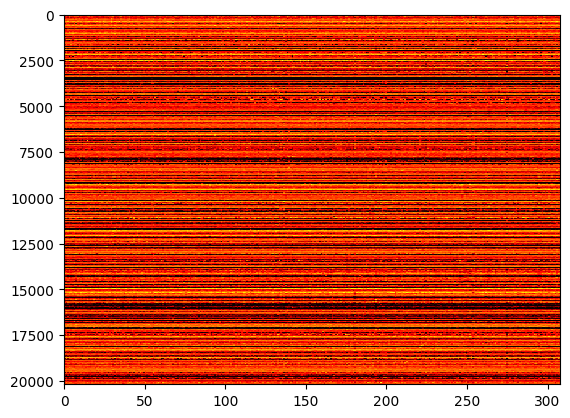

In [5]:
mRNA = raw_mRNA.copy(deep=True)

# Rename first column as 'mRNA ID'
mRNA.rename(columns = {'sample':'mRNA_ID'}, inplace = True)

# Set index as 'mRNA_ID'
mRNA.set_index('mRNA_ID', inplace = True)

# Rename the 'columns' row as 'Sample'
mRNA.columns.name = 'Sample'

# Fill-NA - 0
mRNA.fillna(0, inplace=True)

# Sampling again
display(mRNA.head())

# Zero features
zero_features = []
for feature in mRNA.index:
    if(np.all(mRNA.loc[feature].values == 0)):
        zero_features.append(feature)
print(f'{len(zero_features)} features in mRNA have all zero values')

# Drop zero features
mRNA.drop(zero_features, inplace=True, axis=0)

# Final shape
print(f'mRNA shape: {mRNA.shape[0]} mRNAs and {mRNA.shape[1]} samples')

# Heatmap
plt.imshow(mRNA, cmap='hot', interpolation='nearest', aspect='auto')
plt.show()

### miRNA

Sample,TCGA-61-1910-01,TCGA-61-1728-01,TCGA-31-1953-01,TCGA-31-1951-01,TCGA-24-1552-01,TCGA-13-1477-01,TCGA-30-1862-01,TCGA-29-1698-01,TCGA-13-0924-01,TCGA-25-1326-01,...,TCGA-23-2078-01,TCGA-13-0891-01,TCGA-24-2289-01,TCGA-13-1481-01,TCGA-13-0761-01,TCGA-24-1545-01,TCGA-61-1907-01,TCGA-04-1638-01,TCGA-23-1118-01,TCGA-13-0723-01
miRNA_ID,,,,,,,,,,,,,,,,,,,,,
MIMAT0019868,0.552600,0.0000,0.330600,0.0000,0.000,1.409282,0.972458,0.0000,0.0,0.825805,...,0.0000,0.0,0.000000,0.691031,0.000,0.0,1.952727,1.006519,0.7392,0.0
MIMAT0019869,0.000000,0.0000,0.000000,0.6873,0.000,0.000000,0.000000,0.0000,0.0,0.000000,...,0.0000,0.0,0.157900,0.000000,0.000,0.0,0.000000,0.000000,0.0000,0.0
MIMAT0019860,0.000000,0.0000,0.000000,0.0000,0.000,0.000000,0.000000,0.0000,0.0,0.000000,...,0.0000,0.0,0.000000,0.000000,0.000,0.0,0.000000,0.000000,0.0000,0.0
MIMAT0019862,0.128700,0.0000,0.825971,0.0000,0.000,0.000000,0.401300,0.3751,0.0,0.000000,...,0.0000,0.0,0.000000,0.000000,0.000,0.0,0.442415,0.265200,0.7392,0.0
MIMAT0019864,0.725257,0.9217,0.330600,0.3842,0.463,0.000000,0.401300,0.0000,0.0,0.825800,...,0.5532,0.0,0.429817,0.386500,0.563,0.0,0.000000,0.682995,0.0000,0.0


0 features in miRNA have all zero values
miRNA shape: 2165 miRNAs and 485 samples


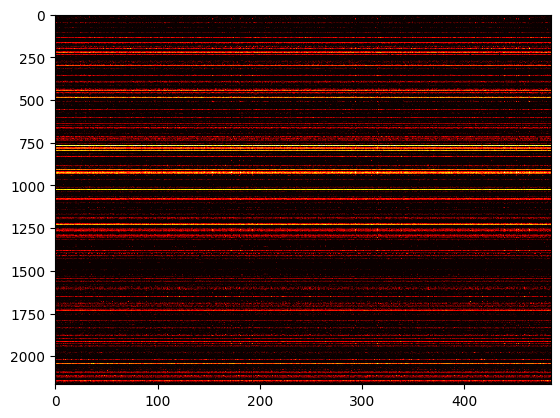

In [6]:
miRNA = raw_miRNA.copy(deep=True)

# Rename first column as 'miRNA ID'
miRNA.rename(columns = {'sample':'miRNA_ID'}, inplace = True)

# Set index as 'miRNA_ID'
miRNA.set_index('miRNA_ID', inplace = True)

# Rename the 'columns' row as 'Sample'
miRNA.columns.name = 'Sample'

# Fill-NA - 0
miRNA.fillna(0, inplace=True)

# Sampling again
display(miRNA.head())

# Zero features
zero_features = []
for feature in miRNA.index:
    if(np.all(miRNA.loc[feature].values == 0)):
        zero_features.append(feature)
print(f'{len(zero_features)} features in miRNA have all zero values')

# Drop zero features
miRNA.drop(zero_features, inplace=True, axis=0)

# Final shape
print(f'miRNA shape: {miRNA.shape[0]} miRNAs and {miRNA.shape[1]} samples')

# Heatmap
plt.imshow(miRNA, cmap='hot', interpolation='nearest', aspect='auto')
plt.show()

### DNA Methylation

Sample,TCGA-61-1910-01,TCGA-61-1728-01,TCGA-72-4238-01,TCGA-13-1819-02,TCGA-31-1953-01,TCGA-13-1819-01,TCGA-25-2392-01,TCGA-31-1951-01,TCGA-24-1552-01,TCGA-13-1477-01,...,TCGA-61-1916-02,TCGA-13-0761-01,TCGA-24-1545-01,TCGA-10-0935-01,TCGA-01-0633-11,TCGA-04-1638-01,TCGA-23-1118-01,TCGA-13-1479-01,TCGA-36-2547-01,TCGA-13-0723-01
methDNA_ID,,,,,,,,,,,,,,,,,,,,,
cg00000292,0.8414,0.9466,0.7846,0.7734,0.7804,0.8053,0.8874,0.8978,0.8990,0.8477,...,0.8070,0.9120,0.8506,0.8021,0.8675,0.6975,0.9012,0.9470,0.8258,0.7648
cg00002426,0.0384,0.1052,0.1157,0.7666,0.0808,0.3654,0.2355,0.0806,0.0202,0.0621,...,0.1802,0.1383,0.2008,0.0380,0.2057,0.0258,0.0863,0.5834,0.1884,0.2807
cg00003994,0.0817,0.0601,0.0554,0.0284,0.0303,0.0438,0.0418,0.7448,0.0235,0.2692,...,0.0422,0.0933,0.0182,0.6720,0.0327,0.0453,0.0363,0.0494,0.0450,0.0637
cg00005847,0.0443,0.4241,0.7966,0.1780,0.6370,0.5863,0.8103,0.3585,0.0579,0.5206,...,0.6025,0.7453,0.2712,0.4855,0.4610,0.9007,0.5696,0.1223,0.6160,0.2648
cg00006414,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,...,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000


Zero features calculation: 100%|██████████| 27578/27578 [00:00<00:00, 29472.34it/s]


2597 features in methDNA have all zero values
methDNA shape: 10480 methDNAs and 616 samples


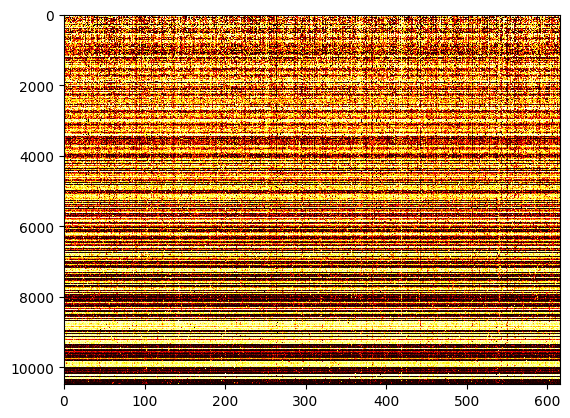

In [7]:
methDNA = raw_methDNA.copy(deep=True)

# Rename first column as 'methDNA ID'
methDNA.rename(columns = {'sample':'methDNA_ID'}, inplace = True)

# Set index as 'methDNA_ID'
methDNA.set_index('methDNA_ID', inplace = True)

# Rename the 'columns' row as 'Sample'
methDNA.columns.name = 'Sample'

# Fill-NA - 0
methDNA.fillna(0, inplace=True)

# Sampling again
display(methDNA.head())

# Zero features
zero_features = []
for feature in tqdm(methDNA.index, desc='Zero features calculation'):
    if(np.all(methDNA.loc[feature].values == 0)):
        zero_features.append(feature)
print(f'{len(zero_features)} features in methDNA have all zero values')

# Drop zero features
methDNA.drop(zero_features, inplace=True, axis=0)

# Top hi-variant features
Ariel = methDNA.var(axis=1).sort_values(ascending=False).head(10480)
methDNA = methDNA.loc[Ariel.index].copy(deep=True)

# Final shape
print(f'methDNA shape: {methDNA.shape[0]} methDNAs and {methDNA.shape[1]} samples')

# Heatmap
plt.imshow(methDNA, cmap='hot', interpolation='nearest', aspect='auto')
plt.show()

### Bipartite Graph

miRNA_ID,MIMAT0000441,MIMAT0000755,MIMAT0000250,MIMAT0000064,MIMAT0000098,MIMAT0000075,MIMAT0000732,MIMAT0002834,MIMAT0000255,MIMAT0000278,...,MIMAT0002172,MIMAT0000736,MIMAT0000252,MIMAT0000770,MIMAT0001545,MIMAT0000692,MIMAT0000753,MIMAT0000450,MIMAT0000081,MIMAT0000281
mRNA_ID,,,,,,,,,,,,,,,,,,,,,
ARF5,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
M6PR,1,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
FKBP4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
CYP26B1,0,0,0,0,1,1,0,1,0,0,...,0,0,0,0,0,0,1,0,0,0
FUCA2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


Bipart shape: 11329 mRNAs and 279 miRNAs


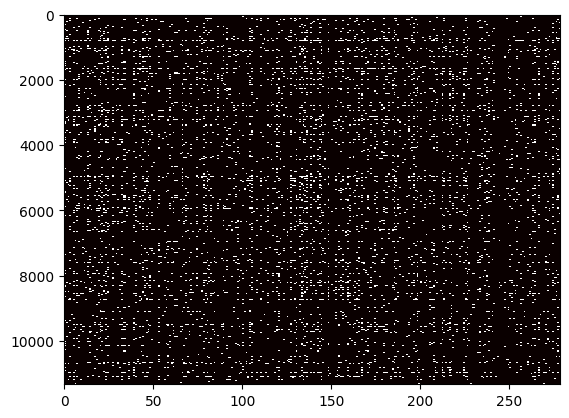

In [8]:
bipart = raw_bipart_data.copy(deep=True)

# Rename first column ('gene_name') as 'mRNA ID'
bipart.rename(columns = {'gene_name':'mRNA_ID'}, inplace = True)

# Set index as 'mRNA_ID'
bipart.set_index('mRNA_ID', inplace = True)

# Rename the 'columns' row as 'miRNA_ID'
bipart.columns.name = 'miRNA_ID'

# Sampling again
display(bipart.head())

# Final shape
print(f'Bipart shape: {bipart.shape[0]} mRNAs and {bipart.shape[1]} miRNAs')

# Heatmap
plt.imshow(bipart, cmap='hot', interpolation='nearest', aspect='auto')
plt.show()

### Clinical Data

In [9]:
clinical = raw_clinical.copy(deep=True)

# Rename first column as 'Sample'
clinical.rename(columns = {'Sample ID': 'Sample'}, inplace = True)

# Set index as 'Sample'
clinical.set_index('Sample', inplace = True)

# Display
display(clinical.head())

# Final shape
print(f'Clinical shape: {clinical.shape[0]} samples and {clinical.shape[1]} features as {list(clinical.columns)}')

,Study ID,Patient ID,Diagnosis Age,Neoplasm Disease Stage American Joint Committee on Cancer Code,American Joint Committee on Cancer Publication Version Type,Aneuploidy Score,Buffa Hypoxia Score,Cancer Type,TCGA PanCanAtlas Cancer Type Acronym,Cancer Type Detailed,...,Subtype,Tissue Prospective Collection Indicator,Tissue Retrospective Collection Indicator,Tissue Source Site,Tissue Source Site Code,TMB (nonsynonymous),Tumor Disease Anatomic Site,Tumor Type,Patient Weight,Winter Hypoxia Score
Sample,,,,,,,,,,,,,,,,,,,,,
TCGA-04-1331-01,ov_tcga_pan_can_atlas_2018,TCGA-04-1331,78.0,NaN,NaN,7.0,NaN,Ovarian Epithelial Tumor,OV,Serous Ovarian Cancer,...,None,None,None,Gynecologic Oncology Group,4,4.500000,Ovary,Serous Cystadenocarcinoma,NaN,NaN
TCGA-04-1332-01,ov_tcga_pan_can_atlas_2018,TCGA-04-1332,70.0,NaN,NaN,15.0,NaN,Ovarian Epithelial Tumor,OV,Serous Ovarian Cancer,...,None,None,None,Gynecologic Oncology Group,4,NaN,Ovary,Serous Cystadenocarcinoma,NaN,NaN
TCGA-04-1335-01,ov_tcga_pan_can_atlas_2018,TCGA-04-1335,60.0,NaN,NaN,6.0,NaN,Ovarian Epithelial Tumor,OV,Serous Ovarian Cancer,...,None,None,None,Gynecologic Oncology Group,4,0.500000,Ovary,Serous Cystadenocarcinoma,NaN,NaN
TCGA-04-1336-01,ov_tcga_pan_can_atlas_2018,TCGA-04-1336,55.0,NaN,NaN,7.0,NaN,Ovarian Epithelial Tumor,OV,Serous Ovarian Cancer,...,None,None,None,Gynecologic Oncology Group,4,2.233333,Ovary,Serous Cystadenocarcinoma,NaN,NaN
TCGA-04-1337-01,ov_tcga_pan_can_atlas_2018,TCGA-04-1337,78.0,NaN,NaN,15.0,NaN,Ovarian Epithelial Tumor,OV,Serous Ovarian Cancer,...,None,None,None,Gynecologic Oncology Group,4,0.000000,Ovary,Serous Cystadenocarcinoma,NaN,NaN


Clinical shape: 585 samples and 61 features as ['Study ID', 'Patient ID', 'Diagnosis Age', 'Neoplasm Disease Stage American Joint Committee on Cancer Code', 'American Joint Committee on Cancer Publication Version Type', 'Aneuploidy Score', 'Buffa Hypoxia Score', 'Cancer Type', 'TCGA PanCanAtlas Cancer Type Acronym', 'Cancer Type Detailed', 'Last Communication Contact from Initial Pathologic Diagnosis Date', 'Birth from Initial Pathologic Diagnosis Date', 'Last Alive Less Initial Pathologic Diagnosis Date Calculated Day Value', 'Disease Free (Months)', 'Disease Free Status', 'Months of disease-specific survival', 'Disease-specific Survival status', 'Ethnicity Category', 'Form completion date', 'Fraction Genome Altered', 'Genetic Ancestry Label', 'Neoplasm Histologic Grade', 'Neoadjuvant Therapy Type Administered Prior To Resection Text', 'ICD-10 Classification', 'International Classification of Diseases for Oncology, Third Edition ICD-O-3 Histology Code', 'International Classification o

# Aggregating, Label Engineering & Saving Data

In [17]:
# Sample again all data
display(f'mRNA shape: {mRNA.shape[0]} mRNAs and {mRNA.shape[1]} samples')
# display(mRNA.head())


display(f'miRNA shape: {miRNA.shape[0]} miRNAs and {miRNA.shape[1]} samples')
# display(miRNA.head())


display(f'methDNA shape: {methDNA.shape[0]} methDNAs and {methDNA.shape[1]} samples')
# display(methDNA.head())


display(f'Bipart shape: {bipart.shape[0]} mRNAs and {bipart.shape[1]} miRNAs')
# display(bipart.head())


display(f'Clinical shape: {clinical.shape[0]} samples and {clinical.shape[1]} features as {list(clinical.columns)}')
# display(clinical.head())

'mRNA shape: 20188 mRNAs and 308 samples'

'miRNA shape: 2165 miRNAs and 485 samples'

'methDNA shape: 10480 methDNAs and 616 samples'

'Bipart shape: 11329 mRNAs and 279 miRNAs'

"Clinical shape: 585 samples and 61 features as ['Study ID', 'Patient ID', 'Diagnosis Age', 'Neoplasm Disease Stage American Joint Committee on Cancer Code', 'American Joint Committee on Cancer Publication Version Type', 'Aneuploidy Score', 'Buffa Hypoxia Score', 'Cancer Type', 'TCGA PanCanAtlas Cancer Type Acronym', 'Cancer Type Detailed', 'Last Communication Contact from Initial Pathologic Diagnosis Date', 'Birth from Initial Pathologic Diagnosis Date', 'Last Alive Less Initial Pathologic Diagnosis Date Calculated Day Value', 'Disease Free (Months)', 'Disease Free Status', 'Months of disease-specific survival', 'Disease-specific Survival status', 'Ethnicity Category', 'Form completion date', 'Fraction Genome Altered', 'Genetic Ancestry Label', 'Neoplasm Histologic Grade', 'Neoadjuvant Therapy Type Administered Prior To Resection Text', 'ICD-10 Classification', 'International Classification of Diseases for Oncology, Third Edition ICD-O-3 Histology Code', 'International Classification 

### 2-omic: mRNA and miRNA

#### Sample Aggregation

In [10]:
common_samples_2omics = list(set(mRNA.columns) & set(miRNA.columns))
print(f'Common samples: {len(common_samples_2omics)} - {list(common_samples_2omics)}')
print(f'% of common samples wrt mRNA: {len(common_samples_2omics) / len(mRNA.columns) * 100:.2f}%')
print(f'% of common samples wrt miRNA: {len(common_samples_2omics) / len(miRNA.columns) * 100:.2f}%')
print('\n')

common_mRNAs = list(set(mRNA.index) & set(bipart.index))
print(f'Common mRNAs: {len(common_mRNAs)} - {list(common_mRNAs)}')
print(f'% of common mRNAs wrt mRNA: {len(common_mRNAs) / len(mRNA.index) * 100:.2f}%')
print(f'% of common mRNAs wrt bipart: {len(common_mRNAs) / len(bipart.index) * 100:.2f}%')
print('\n')

common_miRNAs = list(set(miRNA.index) & set(bipart.columns))
print(f'Common miRNAs: {len(common_miRNAs)} - {list(common_miRNAs)}')
print(f'% of common miRNAs wrt miRNA: {len(common_miRNAs) / len(miRNA.index) * 100:.2f}%')
print(f'% of common miRNAs wrt bipart: {len(common_miRNAs) / len(bipart.columns) * 100:.2f}%')

Common samples: 304 - ['TCGA-61-1900-01', 'TCGA-23-1029-01', 'TCGA-36-1576-01', 'TCGA-61-1724-01', 'TCGA-13-0924-01', 'TCGA-25-1870-01', 'TCGA-24-1546-01', 'TCGA-61-2098-01', 'TCGA-13-0800-01', 'TCGA-36-1569-01', 'TCGA-61-2008-02', 'TCGA-30-1718-01', 'TCGA-29-1691-01', 'TCGA-23-1123-01', 'TCGA-20-1684-01', 'TCGA-23-1114-01', 'TCGA-24-2254-01', 'TCGA-25-1328-01', 'TCGA-25-2400-01', 'TCGA-29-1761-01', 'TCGA-24-1844-01', 'TCGA-24-1551-01', 'TCGA-25-1319-01', 'TCGA-30-1857-01', 'TCGA-25-2404-01', 'TCGA-24-1427-01', 'TCGA-25-1631-01', 'TCGA-24-1467-01', 'TCGA-29-1710-01', 'TCGA-25-1623-01', 'TCGA-23-1026-01', 'TCGA-24-1474-01', 'TCGA-59-2354-01', 'TCGA-24-1616-01', 'TCGA-24-1553-01', 'TCGA-25-1632-01', 'TCGA-25-1627-01', 'TCGA-59-2350-01', 'TCGA-61-1738-01', 'TCGA-23-1027-01', 'TCGA-13-A5FT-01', 'TCGA-13-1403-01', 'TCGA-24-1556-01', 'TCGA-36-1568-01', 'TCGA-24-1604-01', 'TCGA-61-2101-01', 'TCGA-61-1741-01', 'TCGA-29-1711-01', 'TCGA-09-2054-01', 'TCGA-13-2060-01', 'TCGA-23-1023-01', 'TCGA-25

In [11]:
# Sort the indexes
common_samples_2omics.sort()
common_mRNAs.sort()
common_miRNAs.sort()

# Align the data
mRNA_common = mRNA.loc[common_mRNAs, common_samples_2omics].copy(deep=True)
miRNA_common = miRNA.loc[common_miRNAs, common_samples_2omics].copy(deep=True)
bipart_common = bipart.loc[common_mRNAs, common_miRNAs].copy(deep=True)


# Zero features for mRNA_common
zero_features = []
for feature in mRNA_common.index:
    if(np.all(mRNA_common.loc[feature].values == 0)):
        zero_features.append(feature)
print(f'{len(zero_features)} features in mRNA_common have all zero values')

# Zero features for miRNA_common
zero_features = []
for feature in miRNA_common.index:
    if(np.all(miRNA_common.loc[feature].values == 0)):
        zero_features.append(feature)
print(f'{len(zero_features)} features in miRNA_common have all zero values')




display(f'Common mRNA shape: {mRNA_common.shape[0]} mRNAs and {mRNA_common.shape[1]} samples')
# display(mRNA_common.head())

display(f'Common miRNA shape: {miRNA_common.shape[0]} miRNAs and {miRNA_common.shape[1]} samples')
# display(miRNA_common.head())

display(f'Common bipart shape: {bipart_common.shape[0]} mRNAs and {bipart_common.shape[1]} miRNAs')
# display(bipart_common.head())


0 features in mRNA_common have all zero values
0 features in miRNA_common have all zero values


'Common mRNA shape: 10479 mRNAs and 304 samples'

'Common miRNA shape: 274 miRNAs and 304 samples'

'Common bipart shape: 10479 mRNAs and 274 miRNAs'

#### Saving

In [ ]:
if s3 is not None:
    if not s3.exists(f'{DATA_PATH}/processed_2_omics_mRNA_miRNA'):
        s3.makedirs(f'{DATA_PATH}/processed_2_omics_mRNA_miRNA')
    if not s3.exists(f'{DATA_PATH}/clinical_testdata_2_omics_mRNA_miRNA'):
        s3.makedirs(f'{DATA_PATH}/clinical_testdata_2_omics_mRNA_miRNA')
else:
    if not os.path.exists(f'{DATA_PATH}/processed_2_omics_mRNA_miRNA'):
        os.makedirs(f'{DATA_PATH}/processed_2_omics_mRNA_miRNA')
    if not os.path.exists(f'{DATA_PATH}/clinical_testdata_2_omics_mRNA_miRNA'):
        os.makedirs(f'{DATA_PATH}/clinical_testdata_2_omics_mRNA_miRNA')



if OVERRIDE_EXISTING_2_OMICS:
    mRNA_common.to_parquet(f'{DATA_PATH}/processed_2_omics_mRNA_miRNA/mRNA.parquet', storage_options=storage_options)
    miRNA_common.to_parquet(f'{DATA_PATH}/processed_2_omics_mRNA_miRNA/miRNA.parquet', storage_options=storage_options)
    bipart_common.to_parquet(f'{DATA_PATH}/processed_2_omics_mRNA_miRNA/bipart.parquet', storage_options=storage_options)
    clinical.to_parquet(f'{DATA_PATH}/processed_2_omics_mRNA_miRNA/clinical.parquet', storage_options=storage_options)

#### Label Engineering: Clinical Aggregation

In [12]:
import random
from sklearn.model_selection import train_test_split
common_samples_2omics_for_clinical = list(set(common_samples_2omics) & set(clinical.index))
clinical_common_2omics = clinical.loc[common_samples_2omics_for_clinical].copy(deep=True)

print(f'Common samples eligible for threshold engineering: {len(clinical_common_2omics)}')
display(clinical_common_2omics.head())

Common samples eligible for threshold engineering: 298


,Study ID,Patient ID,Diagnosis Age,Neoplasm Disease Stage American Joint Committee on Cancer Code,American Joint Committee on Cancer Publication Version Type,Aneuploidy Score,Buffa Hypoxia Score,Cancer Type,TCGA PanCanAtlas Cancer Type Acronym,Cancer Type Detailed,...,Subtype,Tissue Prospective Collection Indicator,Tissue Retrospective Collection Indicator,Tissue Source Site,Tissue Source Site Code,TMB (nonsynonymous),Tumor Disease Anatomic Site,Tumor Type,Patient Weight,Winter Hypoxia Score
Sample,,,,,,,,,,,,,,,,,,,,,
TCGA-61-1900-01,ov_tcga_pan_can_atlas_2018,TCGA-61-1900,51.0,NaN,NaN,9.0,-3.0,Ovarian Epithelial Tumor,OV,Serous Ovarian Cancer,...,OV,None,None,University of Pittsburgh,61,2.7,Ovary,Serous Cystadenocarcinoma,NaN,26.0
TCGA-23-1029-01,ov_tcga_pan_can_atlas_2018,TCGA-23-1029,46.0,NaN,NaN,7.0,17.0,Ovarian Epithelial Tumor,OV,Serous Ovarian Cancer,...,OV,None,None,Cedars Sinai,23,2.4,Ovary,Serous Cystadenocarcinoma,NaN,14.0
TCGA-36-1576-01,ov_tcga_pan_can_atlas_2018,TCGA-36-1576,76.0,NaN,NaN,23.0,11.0,Ovarian Epithelial Tumor,OV,Serous Ovarian Cancer,...,None,None,None,BC Cancer Agency,36,0.0,Ovary,Serous Cystadenocarcinoma,NaN,20.0
TCGA-61-1724-01,ov_tcga_pan_can_atlas_2018,TCGA-61-1724,47.0,NaN,NaN,9.0,21.0,Ovarian Epithelial Tumor,OV,Serous Ovarian Cancer,...,None,None,None,University of Pittsburgh,61,0.0,Ovary,Serous Cystadenocarcinoma,NaN,-4.0
TCGA-13-0924-01,ov_tcga_pan_can_atlas_2018,TCGA-13-0924,NaN,NaN,NaN,11.0,35.0,Ovarian Epithelial Tumor,OV,Serous Ovarian Cancer,...,None,None,None,Memorial Sloan Kettering,13,0.0,None,Ovarian Serous Cystadenocarcinoma,NaN,28.0


#### Label Engineering: EDA

In [22]:
if (s3 is not None and not s3.exists(f'{DATA_PATH}/reports/2_omics_mRNA_miRNA/diseasefree_report.xlsx')) or (s3 is None and not os.path.exists(f'{DATA_PATH}/reports/2_omics_mRNA_miRNA/diseasefree_report.xlsx')) or True:
    survival = sorted(clinical_common_2omics['Overall Survival (Months)'].dropna().apply(int).unique().tolist())
    print(f'Overall Survival: {len(survival)} - {np.array(survival)}')
    survival_report = pd.DataFrame(columns=['Dead Threshold', 'Long-living Threshold', 'Short-lived Count', 'Long-living Count', 'No Info'])
    for i in range(len(survival)):
        for j in range(i, len(survival)):
            dead_thresh = survival[i]
            longlive_thresh = survival[j]

            dead = clinical_common_2omics[(
                ((clinical_common_2omics['Overall Survival (Months)'] < dead_thresh) if dead_thresh == longlive_thresh else (clinical_common_2omics['Overall Survival (Months)'] <= dead_thresh))
                & (clinical_common_2omics['Overall Survival Status'] == '1:DECEASED')
            )]
            longlive = clinical_common_2omics[clinical_common_2omics['Overall Survival (Months)'] >= longlive_thresh]
            survival_report.loc[len(survival_report)] = [dead_thresh, longlive_thresh, dead.shape[0], longlive.shape[0], clinical_common_2omics.shape[0] - dead.shape[0] - longlive.shape[0]]

    survival_report['SL/LL Ratio'] = survival_report['Short-lived Count'] / survival_report['Long-living Count']
    survival_report['SL/LL Ratio'] = survival_report['SL/LL Ratio'].apply(lambda x: round(x, 4))
    survival_report['LL/SL Ratio'] = survival_report['Long-living Count'] / survival_report['Short-lived Count']
    survival_report['LL/SL Ratio'] = survival_report['LL/SL Ratio'].apply(lambda x: round(x, 4))
    survival_report['Diff'] = np.abs(survival_report['Short-lived Count'] - survival_report['Long-living Count'])
    survival_report.to_excel(f'{DATA_PATH}/reports/2_omics_mRNA_miRNA/survival_report.xlsx', storage_options=storage_options)


    cancrfree = sorted(clinical_common_2omics['Disease Free (Months)'].dropna().apply(int).unique().tolist())
    print(f'Cancer Free: {len(cancrfree)} - {np.array(cancrfree)}')
    diseasefree_report = pd.DataFrame(columns=['Recur Threshold', 'No-Recur Threshold', 'Recur Count', 'No-Recur Count', 'No Info'])
    for i in range(len(cancrfree)):
        for j in range(i, len(cancrfree)):
            recur_thresh = cancrfree[i]
            norecur_thresh = cancrfree[j]

            recur = clinical_common_2omics[(
                ((clinical_common_2omics['Disease Free (Months)'] < recur_thresh) if recur_thresh == norecur_thresh else (clinical_common_2omics['Disease Free (Months)'] <= recur_thresh))
                & (clinical_common_2omics['Disease Free Status'] == '1:Recur')
            )]
            norecur = clinical_common_2omics[clinical_common_2omics['Disease Free (Months)'] >= norecur_thresh]
            diseasefree_report.loc[len(diseasefree_report)] = [recur_thresh, norecur_thresh, recur.shape[0], norecur.shape[0], clinical_common_2omics.shape[0] - recur.shape[0] - norecur.shape[0]]
            
    diseasefree_report['R/NR Ratio'] = diseasefree_report['Recur Count'] / diseasefree_report['No-Recur Count']
    diseasefree_report['R/NR Ratio'] = diseasefree_report['R/NR Ratio'].apply(lambda x: round(x, 4))
    diseasefree_report['NR/R Ratio'] = diseasefree_report['No-Recur Count'] / diseasefree_report['Recur Count']
    diseasefree_report['NR/R Ratio'] = diseasefree_report['NR/R Ratio'].apply(lambda x: round(x, 4))
    diseasefree_report['Diff'] = np.abs(diseasefree_report['Recur Count'] - diseasefree_report['No-Recur Count'])
    diseasefree_report.to_excel(f'{DATA_PATH}/reports/2_omics_mRNA_miRNA/diseasefree_report.xlsx', storage_options=storage_options)

Overall Survival: 90 - [  0   1   2   3   4   5   6   7   8   9  11  12  13  14  15  16  17  18
  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35  36
  37  38  39  40  41  42  43  44  45  47  48  49  51  52  53  54  55  56
  57  58  59  60  61  62  63  64  65  66  67  68  70  71  72  76  77  78
  81  83  85  86  87  88  89  90 101 105 109 115 116 125 127 145 152 180]
Cancer Free: 50 - [  3   4   5   6   7   8   9  10  11  12  13  14  15  16  17  18  19  20
  21  22  23  25  26  27  28  29  30  31  32  34  35  37  38  40  41  43
  44  45  49  51  52  55  58  60  65  70  71  87 145 180]


#### Label Engineering: Build & Save Dataset

In [23]:
from sklearn.model_selection import train_test_split
from tqdm import tqdm
import random


test_passes = 100
threshold_aio = [
    (18, 18, 'survival'),
    (12, 18, 'diseasefree'),
    (12, 12, 'diseasefree'),
]



test_index = [f'Test{i:03}' for i in range(TEST_PASS)]
for lo_bound, up_bound, label_type in threshold_aio:
    clinical_testdata = pd.DataFrame(
        index = test_index,
        columns = ['train_sample_ids', 'test_sample_ids', 'train_ground_truth', 'test_ground_truth']
    )
    if label_type == 'survival':
        negative_samples = clinical_common_2omics[(
            ((clinical_common_2omics['Overall Survival (Months)'] <= lo_bound) if lo_bound != up_bound else (clinical_common_2omics['Overall Survival (Months)'] < lo_bound))
            & (clinical_common_2omics['Overall Survival Status'] == '1:DECEASED')
        )].index.to_list()
        positive_samples = clinical_common_2omics[clinical_common_2omics['Overall Survival (Months)'] >= up_bound].index.to_list()
    else:
        negative_samples = clinical_common_2omics[(
            ((clinical_common_2omics['Disease Free (Months)'] <= lo_bound) if lo_bound != up_bound else (clinical_common_2omics['Disease Free (Months)'] < lo_bound))
            & (clinical_common_2omics['Disease Free Status'] == '1:Recurred/Progressed')
        )].index.to_list() 
        positive_samples = clinical_common_2omics[clinical_common_2omics['Disease Free (Months)'] >= up_bound].index.to_list()
    label = f'{label_type}_{lo_bound}_{up_bound}'

    print(f'Label: {label}')
    print(f'Negative samples aka {label_type} <=/< {lo_bound} months: {len(negative_samples)}')
    print(f'Positive samples aka {label_type} >= {up_bound} months: {len(positive_samples)}')

    label_dict = {s:1 for s in positive_samples}
    label_dict.update({s:0 for s in negative_samples})
    for test_pass in tqdm(range(test_passes), desc=f'Building testcases for {label}'):
        pos_train_idx, pos_test_idx = train_test_split(positive_samples, test_size=0.2)
        neg_train_idx, neg_test_idx = train_test_split(negative_samples, test_size=0.2)

        train_idx = pos_train_idx + neg_train_idx
        test_idx = pos_test_idx + neg_test_idx
        random.shuffle(train_idx)
        random.shuffle(test_idx)

        clinical_testdata.loc[f'Test{test_pass:03}', 'train_sample_ids'] = train_idx
        clinical_testdata.loc[f'Test{test_pass:03}', 'test_sample_ids'] = test_idx
        clinical_testdata.loc[f'Test{test_pass:03}', 'train_ground_truth'] = [label_dict[s] for s in train_idx]
        clinical_testdata.loc[f'Test{test_pass:03}', 'test_ground_truth'] = [label_dict[s] for s in test_idx]


    # if OVERRIDE_EXISTING_2_OMICS:
    #     clinical_testdata.to_parquet(f'{DATA_PATH}/clinical_testdata_2_omics_mRNA_miRNA/{label}.parquet', storage_options=storage_options)

Label: survival_18_18
Negative samples aka survival <=/< 18 months: 40
Positive samples aka survival >= 18 months: 207


Building testcases for survival_18_18: 100%|██████████| 100/100 [00:00<00:00, 1291.92it/s]


Label: diseasefree_12_18
Negative samples aka diseasefree <=/< 12 months: 17
Positive samples aka diseasefree >= 18 months: 71


Building testcases for diseasefree_12_18: 100%|██████████| 100/100 [00:00<00:00, 1817.49it/s]


Label: diseasefree_12_12
Negative samples aka diseasefree <=/< 12 months: 17
Positive samples aka diseasefree >= 12 months: 105


Building testcases for diseasefree_12_12: 100%|██████████| 100/100 [00:00<00:00, 1672.94it/s]


#### Survival Analysis

In [13]:
survival_common_2omics = (
    clinical_common_2omics[['Overall Survival Status', 'Overall Survival (Months)']]
    .dropna()
    .copy(deep=True)
)
survival_common_2omics['Overall Survival Status'] = survival_common_2omics['Overall Survival Status'].apply(lambda x: str(x).split(':')[0] == '1')

diseasefree_common_2omics = (
    clinical_common_2omics[['Disease Free Status', 'Disease Free (Months)']]
    .dropna()
    .copy(deep=True)
)
diseasefree_common_2omics['Disease Free Status'] = diseasefree_common_2omics['Disease Free Status'].apply(lambda x: str(x).split(':')[0] == '1')

display(survival_common_2omics['Overall Survival Status'].value_counts())
display(diseasefree_common_2omics['Disease Free Status'].value_counts())

if OVERRIDE_EXISTING_2_OMICS:
    survival_common_2omics.to_parquet(f'{DATA_PATH}/survivalanalysis_testdata_2_omics_mRNA_miRNA/survival.parquet', storage_options=storage_options)
    diseasefree_common_2omics.to_parquet(f'{DATA_PATH}/survivalanalysis_testdata_2_omics_mRNA_miRNA/diseasefree.parquet', storage_options=storage_options)

Overall Survival Status
True     178
False    119
Name: count, dtype: int64

Disease Free Status
True     95
False    46
Name: count, dtype: int64

### 3-omic: mRNA, miRNA, and DNA methylation

#### Sample Aggregation

In [14]:
common_samples_3omics = list(set(mRNA.columns) & set(miRNA.columns) & set(methDNA.columns))
print(f'Common samples: {len(common_samples_3omics)} - {list(common_samples_2omics)}')
print(f'% of common samples wrt mRNA: {len(common_samples_3omics) / len(mRNA.columns) * 100:.2f}%')
print(f'% of common samples wrt miRNA: {len(common_samples_3omics) / len(miRNA.columns) * 100:.2f}%')
print(f'% of common samples wrt methDNA: {len(common_samples_3omics) / len(methDNA.columns) * 100:.2f}%')
print(f'% of common samples wrt 2-omics: {len(common_samples_3omics) / len(common_samples_2omics) * 100:.2f}%')
print('\n')

common_mRNAs = list(set(mRNA.index) & set(bipart.index))
print(f'Common mRNAs: {len(common_mRNAs)} - {list(common_mRNAs)}')
print(f'% of common mRNAs wrt mRNA: {len(common_mRNAs) / len(mRNA.index) * 100:.2f}%')
print(f'% of common mRNAs wrt bipart: {len(common_mRNAs) / len(bipart.index) * 100:.2f}%')
print('\n')

common_miRNAs = list(set(miRNA.index) & set(bipart.columns))
print(f'Common miRNAs: {len(common_miRNAs)} - {list(common_miRNAs)}')
print(f'% of common miRNAs wrt miRNA: {len(common_miRNAs) / len(miRNA.index) * 100:.2f}%')
print(f'% of common miRNAs wrt bipart: {len(common_miRNAs) / len(bipart.columns) * 100:.2f}%')

Common samples: 295 - ['TCGA-04-1348-01', 'TCGA-04-1357-01', 'TCGA-04-1362-01', 'TCGA-04-1364-01', 'TCGA-04-1365-01', 'TCGA-04-1514-01', 'TCGA-04-1519-01', 'TCGA-09-0364-01', 'TCGA-09-0366-01', 'TCGA-09-0367-01', 'TCGA-09-1662-01', 'TCGA-09-1666-01', 'TCGA-09-1667-01', 'TCGA-09-1668-01', 'TCGA-09-1669-01', 'TCGA-09-1670-01', 'TCGA-09-1673-01', 'TCGA-09-1674-01', 'TCGA-09-2044-01', 'TCGA-09-2045-01', 'TCGA-09-2048-01', 'TCGA-09-2051-01', 'TCGA-09-2054-01', 'TCGA-10-0928-01', 'TCGA-10-0936-01', 'TCGA-13-0730-01', 'TCGA-13-0799-01', 'TCGA-13-0800-01', 'TCGA-13-0801-01', 'TCGA-13-0890-01', 'TCGA-13-0893-01', 'TCGA-13-0897-01', 'TCGA-13-0899-01', 'TCGA-13-0913-01', 'TCGA-13-0916-01', 'TCGA-13-0920-01', 'TCGA-13-0924-01', 'TCGA-13-1403-01', 'TCGA-13-1405-01', 'TCGA-13-1410-01', 'TCGA-13-1411-01', 'TCGA-13-1481-01', 'TCGA-13-1489-02', 'TCGA-13-1497-01', 'TCGA-13-1498-01', 'TCGA-13-1505-01', 'TCGA-13-1506-01', 'TCGA-13-1507-01', 'TCGA-13-1511-01', 'TCGA-13-1512-01', 'TCGA-13-2060-01', 'TCGA-13

In [16]:
# Sort the indexes
common_samples_3omics.sort()
common_mRNAs.sort()
common_miRNAs.sort()

# Align the data
mRNA_common = mRNA.loc[common_mRNAs, common_samples_3omics].copy(deep=True)
miRNA_common = miRNA.loc[common_miRNAs, common_samples_3omics].copy(deep=True)
methDNA_common = methDNA.loc[:, common_samples_3omics].copy(deep=True)
bipart_common = bipart.loc[common_mRNAs, common_miRNAs].copy(deep=True)


# Zero features for mRNA_common
zero_features = []
for feature in mRNA_common.index:
    if(np.all(mRNA_common.loc[feature].values == 0)):
        zero_features.append(feature)
print(f'{len(zero_features)} features in mRNA_common have all zero values:', zero_features)
if len(zero_features) > 0: 
    mRNA_common.drop(zero_features, inplace=True, axis=0)

# Zero features for miRNA_common
zero_features = []
for feature in miRNA_common.index:
    if(np.all(miRNA_common.loc[feature].values == 0)):
        zero_features.append(feature)
print(f'{len(zero_features)} features in miRNA_common have all zero values', zero_features)
if len(zero_features) > 0:  
    miRNA_common.drop(zero_features, inplace=True, axis=0)

# Zero features for methDNA_common
zero_features = []
for feature in methDNA_common.index:
    if(np.all(methDNA_common.loc[feature].values == 0)):
        zero_features.append(feature)
print(f'{len(zero_features)} features in methDNA_common have all zero values', zero_features)
if len(zero_features) > 0:  
    methDNA_common.drop(zero_features, inplace=True, axis=0)


# Re-align again
bipart_common = bipart_common.loc[mRNA_common.index, miRNA_common.index].copy(deep=True)



display(f'Common mRNA shape: {mRNA_common.shape[0]} mRNAs and {mRNA_common.shape[1]} samples')
display(mRNA_common.head())

display(f'Common miRNA shape: {miRNA_common.shape[0]} miRNAs and {miRNA_common.shape[1]} samples')
display(miRNA_common.head())

display(f'Common methDNA shape: {methDNA_common.shape[0]} methDNAs and {methDNA_common.shape[1]} samples')
display(methDNA_common.head())

display(f'Common bipart shape: {bipart_common.shape[0]} mRNAs and {bipart_common.shape[1]} miRNAs')
display(bipart_common.head())



0 features in mRNA_common have all zero values: []
4 features in miRNA_common have all zero values ['MIMAT0000241', 'MIMAT0000715', 'MIMAT0004922', 'MIMAT0004960']
0 features in methDNA_common have all zero values []


'Common mRNA shape: 10479 mRNAs and 295 samples'

Sample,TCGA-04-1348-01,TCGA-04-1357-01,TCGA-04-1362-01,TCGA-04-1364-01,TCGA-04-1365-01,TCGA-04-1514-01,TCGA-04-1519-01,TCGA-09-0364-01,TCGA-09-0366-01,TCGA-09-0367-01,...,TCGA-61-2095-01,TCGA-61-2097-01,TCGA-61-2098-01,TCGA-61-2101-01,TCGA-61-2102-01,TCGA-61-2104-01,TCGA-61-2109-01,TCGA-61-2110-01,TCGA-61-2111-01,TCGA-61-2113-01
mRNA_ID,,,,,,,,,,,,,,,,,,,,,
A1BG,6.0762,6.0567,5.4142,7.5549,4.6398,5.0795,5.5650,7.3563,6.4847,7.5979,...,6.5410,5.2317,7.3013,7.3552,6.0157,6.6460,5.2990,7.1433,6.5806,6.1586
A1CF,0.0000,0.0000,0.4125,0.0000,0.0000,0.0000,0.0000,0.9286,0.0000,0.0000,...,0.5961,0.0000,0.6406,0.0000,0.0000,0.0000,0.0000,1.5389,0.0000,0.0000
A4GNT,0.6209,0.0000,0.0000,0.0000,0.6805,0.8981,0.0000,1.2358,1.6074,1.6406,...,3.1166,0.7821,0.0000,0.3743,1.1372,1.0457,2.8477,2.6417,0.6784,0.4323
AAGAB,9.9738,9.3773,9.2942,10.1638,10.3303,9.7287,8.9198,10.2383,10.1968,8.9670,...,9.5363,9.9758,9.8828,9.5864,9.8833,9.6935,10.3546,9.1313,9.6212,10.2996
AAK1,10.9220,10.4399,9.6598,10.2647,10.1384,9.2073,11.0253,9.1123,10.9995,10.8229,...,10.7354,10.5430,10.5196,11.0677,10.5535,11.0349,10.6810,10.0577,11.2380,11.4476


'Common miRNA shape: 270 miRNAs and 295 samples'

Sample,TCGA-04-1348-01,TCGA-04-1357-01,TCGA-04-1362-01,TCGA-04-1364-01,TCGA-04-1365-01,TCGA-04-1514-01,TCGA-04-1519-01,TCGA-09-0364-01,TCGA-09-0366-01,TCGA-09-0367-01,...,TCGA-61-2095-01,TCGA-61-2097-01,TCGA-61-2098-01,TCGA-61-2101-01,TCGA-61-2102-01,TCGA-61-2104-01,TCGA-61-2109-01,TCGA-61-2110-01,TCGA-61-2111-01,TCGA-61-2113-01
miRNA_ID,,,,,,,,,,,,,,,,,,,,,
MIMAT0000062,16.471727,15.836641,16.305966,15.499536,15.483672,14.104003,16.227724,12.948855,14.411871,15.619096,...,17.265753,16.996144,16.500788,16.474017,15.617217,16.377085,16.520540,16.964991,16.300330,16.234423
MIMAT0000063,16.809931,16.149256,16.074727,15.120727,16.358887,14.235049,18.008363,12.157711,15.683184,16.867409,...,17.075449,16.191141,14.735456,15.706239,13.454406,16.062571,15.897134,15.263910,15.395286,15.864365
MIMAT0000064,13.674967,14.333572,13.308891,12.106964,12.734394,11.355395,14.440998,11.862731,13.153581,14.350413,...,12.368959,13.702745,13.984316,15.493656,13.898993,15.867024,15.271230,14.561708,12.296455,13.883136
MIMAT0000065,9.492601,8.861313,9.307303,7.502286,9.096564,7.092028,7.995523,5.351382,7.805330,7.989392,...,8.751122,8.288497,8.631181,8.316190,5.892084,8.899942,9.624664,6.839433,8.733292,9.027311
MIMAT0000066,11.541527,12.737216,11.697319,11.758332,11.443721,10.580158,11.399947,10.583674,10.369197,10.583642,...,13.639234,13.551206,14.233545,13.316136,12.934612,12.367565,13.241546,12.969504,13.161630,14.066687


'Common methDNA shape: 10480 methDNAs and 295 samples'

Sample,TCGA-04-1348-01,TCGA-04-1357-01,TCGA-04-1362-01,TCGA-04-1364-01,TCGA-04-1365-01,TCGA-04-1514-01,TCGA-04-1519-01,TCGA-09-0364-01,TCGA-09-0366-01,TCGA-09-0367-01,...,TCGA-61-2095-01,TCGA-61-2097-01,TCGA-61-2098-01,TCGA-61-2101-01,TCGA-61-2102-01,TCGA-61-2104-01,TCGA-61-2109-01,TCGA-61-2110-01,TCGA-61-2111-01,TCGA-61-2113-01
methDNA_ID,,,,,,,,,,,,,,,,,,,,,
cg11201229,0.9319,0.9264,0.0000,0.9107,0.8993,0.9335,0.9459,0.8953,0.0000,0.0000,...,0.9486,0.0000,0.9344,0.9454,0.0000,0.9445,0.8449,0.0000,0.9318,0.0000
cg27592318,0.9744,0.8954,0.0000,0.6679,0.9526,0.0530,0.9608,0.7068,0.0000,0.0802,...,0.9695,0.9436,0.0000,0.9548,0.9603,0.9147,0.0000,0.0000,0.7576,0.8398
cg09076584,0.9178,0.9430,0.9558,0.7651,0.9508,0.8510,0.9542,0.0000,0.0000,0.9583,...,0.8904,0.9405,0.0000,0.9562,0.9441,0.9505,0.9076,0.9259,0.9086,0.9155
cg25600606,0.9733,0.9761,0.0000,0.9773,0.9750,0.9731,0.9673,0.9445,0.9758,0.9597,...,0.9388,0.0000,0.9824,0.9809,0.0000,0.0000,0.9855,0.9826,0.0000,0.9634
cg00929855,0.0140,0.1825,0.0165,0.7290,0.0096,0.0141,0.0137,0.9788,0.0178,0.1429,...,0.7003,0.7382,0.9631,0.0066,0.9725,0.0296,0.6741,0.0053,0.0203,0.0135


'Common bipart shape: 10479 mRNAs and 270 miRNAs'

miRNA_ID,MIMAT0000062,MIMAT0000063,MIMAT0000064,MIMAT0000065,MIMAT0000066,MIMAT0000067,MIMAT0000068,MIMAT0000069,MIMAT0000070,MIMAT0000072,...,MIMAT0019864,MIMAT0022695,MIMAT0022697,MIMAT0022705,MIMAT0022726,MIMAT0022834,MIMAT0025858,MIMAT0026557,MIMAT0026640,MIMAT0027571
mRNA_ID,,,,,,,,,,,,,,,,,,,,,
A1BG,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
A1CF,1,1,1,1,1,1,1,1,0,0,...,0,0,0,0,0,0,0,0,0,0
A4GNT,0,0,0,0,0,0,1,1,0,0,...,0,0,0,0,0,0,0,0,0,0
AAGAB,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
AAK1,1,1,1,1,1,1,0,0,1,0,...,1,1,1,0,0,0,0,0,1,0


#### Saving

In [26]:
if s3 is not None:
    if not s3.exists(f'{DATA_PATH}/processed_3_omics_mRNA_miRNA_methDNA'):
        s3.makedirs(f'{DATA_PATH}/processed_3_omics_mRNA_miRNA_methDNA')
    if not s3.exists(f'{DATA_PATH}/clinical_testdata_3_omics_mRNA_miRNA_methDNA'):
        s3.makedirs(f'{DATA_PATH}/clinical_testdata_3_omics_mRNA_miRNA_methDNA')
    
else:
    if not os.path.exists(f'{DATA_PATH}/processed_3_omics_mRNA_miRNA_methDNA'):
        os.makedirs(f'{DATA_PATH}/processed_3_omics_mRNA_miRNA_methDNA')
    if not os.path.exists(f'{DATA_PATH}/clinical_testdata_3_omics_mRNA_miRNA_methDNA'):
        os.makedirs(f'{DATA_PATH}/clinical_testdata_3_omics_mRNA_miRNA_methDNA')
    


if OVERRIDE_EXISTING_3_OMICS:
    mRNA_common.to_parquet(f'{DATA_PATH}/processed_3_omics_mRNA_miRNA_methDNA/mRNA.parquet', storage_options=storage_options)
    miRNA_common.to_parquet(f'{DATA_PATH}/processed_3_omics_mRNA_miRNA_methDNA/miRNA.parquet', storage_options=storage_options)
    methDNA_common.to_parquet(f'{DATA_PATH}/processed_3_omics_mRNA_miRNA_methDNA/methDNA.parquet', storage_options=storage_options)
    bipart_common.to_parquet(f'{DATA_PATH}/processed_3_omics_mRNA_miRNA_methDNA/bipart.parquet', storage_options=storage_options)
    clinical.to_parquet(f'{DATA_PATH}/processed_3_omics_mRNA_miRNA_methDNA/clinical.parquet', storage_options=storage_options)



#### Label Engineering: Clinical Aggregation

In [17]:
import random
from sklearn.model_selection import train_test_split
common_samples_3omics_for_clinical = list(set(common_samples_3omics) & set(clinical.index))
clinical_common_3omics = clinical.loc[common_samples_3omics_for_clinical].copy(deep=True)

print(f'Common samples eligible for threshold engineering: {len(clinical_common_3omics)}')
display(clinical_common_3omics.head())

Common samples eligible for threshold engineering: 289


,Study ID,Patient ID,Diagnosis Age,Neoplasm Disease Stage American Joint Committee on Cancer Code,American Joint Committee on Cancer Publication Version Type,Aneuploidy Score,Buffa Hypoxia Score,Cancer Type,TCGA PanCanAtlas Cancer Type Acronym,Cancer Type Detailed,...,Subtype,Tissue Prospective Collection Indicator,Tissue Retrospective Collection Indicator,Tissue Source Site,Tissue Source Site Code,TMB (nonsynonymous),Tumor Disease Anatomic Site,Tumor Type,Patient Weight,Winter Hypoxia Score
Sample,,,,,,,,,,,,,,,,,,,,,
TCGA-61-1900-01,ov_tcga_pan_can_atlas_2018,TCGA-61-1900,51.0,NaN,NaN,9.0,-3.0,Ovarian Epithelial Tumor,OV,Serous Ovarian Cancer,...,OV,None,None,University of Pittsburgh,61,2.7,Ovary,Serous Cystadenocarcinoma,NaN,26.0
TCGA-23-1029-01,ov_tcga_pan_can_atlas_2018,TCGA-23-1029,46.0,NaN,NaN,7.0,17.0,Ovarian Epithelial Tumor,OV,Serous Ovarian Cancer,...,OV,None,None,Cedars Sinai,23,2.4,Ovary,Serous Cystadenocarcinoma,NaN,14.0
TCGA-36-1576-01,ov_tcga_pan_can_atlas_2018,TCGA-36-1576,76.0,NaN,NaN,23.0,11.0,Ovarian Epithelial Tumor,OV,Serous Ovarian Cancer,...,None,None,None,BC Cancer Agency,36,0.0,Ovary,Serous Cystadenocarcinoma,NaN,20.0
TCGA-61-1724-01,ov_tcga_pan_can_atlas_2018,TCGA-61-1724,47.0,NaN,NaN,9.0,21.0,Ovarian Epithelial Tumor,OV,Serous Ovarian Cancer,...,None,None,None,University of Pittsburgh,61,0.0,Ovary,Serous Cystadenocarcinoma,NaN,-4.0
TCGA-13-0924-01,ov_tcga_pan_can_atlas_2018,TCGA-13-0924,NaN,NaN,NaN,11.0,35.0,Ovarian Epithelial Tumor,OV,Serous Ovarian Cancer,...,None,None,None,Memorial Sloan Kettering,13,0.0,None,Ovarian Serous Cystadenocarcinoma,NaN,28.0


#### Label Engineering: EDA

In [28]:
if (s3 is not None and not s3.exists(f'{DATA_PATH}/reports/3_omics_mRNA_miRNA_methDNA/diseasefree_report.xlsx')) or (s3 is None and not os.path.exists(f'{DATA_PATH}/reports/3_omics_mRNA_miRNA_methDNA/diseasefree_report.xlsx')) or True:
    survival = sorted(clinical_common_3omics['Overall Survival (Months)'].dropna().apply(int).unique().tolist())
    print(f'Overall Survival: {len(survival)} - {np.array(survival)}')
    survival_report = pd.DataFrame(columns=['Dead Threshold', 'Long-living Threshold', 'Short-lived Count', 'Long-living Count', 'No Info'])
    for i in range(len(survival)):
        for j in range(i, len(survival)):
            dead_thresh = survival[i]
            longlive_thresh = survival[j]

            dead = clinical_common_3omics[(
                ((clinical_common_3omics['Overall Survival (Months)'] < dead_thresh) if dead_thresh == longlive_thresh else (clinical_common_3omics['Overall Survival (Months)'] <= dead_thresh))
                & (clinical_common_3omics['Overall Survival Status'] == '1:DECEASED')
            )]
            longlive = clinical_common_3omics[clinical_common_3omics['Overall Survival (Months)'] >= longlive_thresh]
            survival_report.loc[len(survival_report)] = [dead_thresh, longlive_thresh, dead.shape[0], longlive.shape[0], clinical_common_3omics.shape[0] - dead.shape[0] - longlive.shape[0]]

    survival_report['SL/LL Ratio'] = survival_report['Short-lived Count'] / survival_report['Long-living Count']
    survival_report['SL/LL Ratio'] = survival_report['SL/LL Ratio'].apply(lambda x: round(x, 4))
    survival_report['LL/SL Ratio'] = survival_report['Long-living Count'] / survival_report['Short-lived Count']
    survival_report['LL/SL Ratio'] = survival_report['LL/SL Ratio'].apply(lambda x: round(x, 4))
    survival_report['Diff'] = np.abs(survival_report['Short-lived Count'] - survival_report['Long-living Count'])
    survival_report.to_excel(f'{DATA_PATH}/reports/3_omics_mRNA_miRNA_methDNA/survival_report.xlsx', storage_options=storage_options)


    cancrfree = sorted(clinical_common_3omics['Disease Free (Months)'].dropna().apply(int).unique().tolist())
    print(f'Cancer Free: {len(cancrfree)} - {np.array(cancrfree)}')
    diseasefree_report = pd.DataFrame(columns=['Recur Threshold', 'No-Recur Threshold', 'Recur Count', 'No-Recur Count', 'No Info'])
    for i in range(len(cancrfree)):
        for j in range(i, len(cancrfree)):
            recur_thresh = cancrfree[i]
            norecur_thresh = cancrfree[j]

            recur = clinical_common_3omics[(
                ((clinical_common_3omics['Disease Free (Months)'] < recur_thresh) if recur_thresh == norecur_thresh else (clinical_common_3omics['Disease Free (Months)'] <= recur_thresh))
                & (clinical_common_3omics['Disease Free Status'] == '1:Recur')
            )]
            norecur = clinical_common_3omics[clinical_common_3omics['Disease Free (Months)'] >= norecur_thresh]
            diseasefree_report.loc[len(diseasefree_report)] = [recur_thresh, norecur_thresh, recur.shape[0], norecur.shape[0], clinical_common_3omics.shape[0] - recur.shape[0] - norecur.shape[0]]
            
    diseasefree_report['R/NR Ratio'] = diseasefree_report['Recur Count'] / diseasefree_report['No-Recur Count']
    diseasefree_report['R/NR Ratio'] = diseasefree_report['R/NR Ratio'].apply(lambda x: round(x, 4))
    diseasefree_report['NR/R Ratio'] = diseasefree_report['No-Recur Count'] / diseasefree_report['Recur Count']
    diseasefree_report['NR/R Ratio'] = diseasefree_report['NR/R Ratio'].apply(lambda x: round(x, 4))
    diseasefree_report['Diff'] = np.abs(diseasefree_report['Recur Count'] - diseasefree_report['No-Recur Count'])
    diseasefree_report.to_excel(f'{DATA_PATH}/reports/3_omics_mRNA_miRNA_methDNA/diseasefree_report.xlsx', storage_options=storage_options)

Overall Survival: 90 - [  0   1   2   3   4   5   6   7   8   9  11  12  13  14  15  16  17  18
  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35  36
  37  38  39  40  41  42  43  44  45  47  48  49  51  52  53  54  55  56
  57  58  59  60  61  62  63  64  65  66  67  68  70  71  72  76  77  78
  81  83  85  86  87  88  89  90 101 105 109 115 116 125 127 145 152 180]
Cancer Free: 50 - [  3   4   5   6   7   8   9  10  11  12  13  14  15  16  17  18  19  20
  21  22  23  25  26  27  28  29  30  31  32  34  35  37  38  40  41  43
  44  45  49  51  52  55  58  60  65  70  71  87 145 180]


#### Label Engineering: Build & Save Dataset

In [29]:
from sklearn.model_selection import train_test_split
from tqdm import tqdm
import random


test_passes = 100
threshold_aio = [
    (18, 18, 'survival'),
    (12, 18, 'diseasefree'),
    (12, 12, 'diseasefree'),
]



test_index = [f'Test{i:03}' for i in range(TEST_PASS)]
for lo_bound, up_bound, label_type in threshold_aio:
    clinical_testdata = pd.DataFrame(
        index = test_index,
        columns = ['train_sample_ids', 'test_sample_ids', 'train_ground_truth', 'test_ground_truth']
    )
    if label_type == 'survival':
        negative_samples = clinical_common_3omics[(
            ((clinical_common_3omics['Overall Survival (Months)'] <= lo_bound) if lo_bound != up_bound else (clinical_common_3omics['Overall Survival (Months)'] < lo_bound))
            & (clinical_common_3omics['Overall Survival Status'] == '1:DECEASED')
        )].index.to_list()
        positive_samples = clinical_common_3omics[clinical_common_3omics['Overall Survival (Months)'] >= up_bound].index.to_list()
    else:
        negative_samples = clinical_common_3omics[(
            ((clinical_common_3omics['Disease Free (Months)'] <= lo_bound) if lo_bound != up_bound else (clinical_common_3omics['Disease Free (Months)'] < lo_bound))
            & (clinical_common_3omics['Disease Free Status'] == '1:Recurred/Progressed')
        )].index.to_list() 
        positive_samples = clinical_common_3omics[clinical_common_3omics['Disease Free (Months)'] >= up_bound].index.to_list()
    label = f'{label_type}_{lo_bound}_{up_bound}'

    print(f'Label: {label}')
    print(f'Negative samples aka {label_type} <=/< {lo_bound} months: {len(negative_samples)}')
    print(f'Positive samples aka {label_type} >= {up_bound} months: {len(positive_samples)}')

    label_dict = {s:1 for s in positive_samples}
    label_dict.update({s:0 for s in negative_samples})
    for test_pass in tqdm(range(test_passes), desc=f'Building testcases for {label}'):
        pos_train_idx, pos_test_idx = train_test_split(positive_samples, test_size=0.2)
        neg_train_idx, neg_test_idx = train_test_split(negative_samples, test_size=0.2)

        train_idx = pos_train_idx + neg_train_idx
        test_idx = pos_test_idx + neg_test_idx
        random.shuffle(train_idx)
        random.shuffle(test_idx)

        clinical_testdata.loc[f'Test{test_pass:03}', 'train_sample_ids'] = train_idx
        clinical_testdata.loc[f'Test{test_pass:03}', 'test_sample_ids'] = test_idx
        clinical_testdata.loc[f'Test{test_pass:03}', 'train_ground_truth'] = [label_dict[s] for s in train_idx]
        clinical_testdata.loc[f'Test{test_pass:03}', 'test_ground_truth'] = [label_dict[s] for s in test_idx]


    if OVERRIDE_EXISTING_3_OMICS:
        clinical_testdata.to_parquet(f'{DATA_PATH}/clinical_testdata_3_omics_mRNA_miRNA_methDNA/{label}.parquet', storage_options=storage_options)

Label: survival_18_18
Negative samples aka survival <=/< 18 months: 38
Positive samples aka survival >= 18 months: 202


Building testcases for survival_18_18: 100%|██████████| 100/100 [00:00<00:00, 1531.21it/s]


Label: diseasefree_12_18
Negative samples aka diseasefree <=/< 12 months: 15
Positive samples aka diseasefree >= 18 months: 68


Building testcases for diseasefree_12_18: 100%|██████████| 100/100 [00:00<00:00, 1840.95it/s]


Label: diseasefree_12_12
Negative samples aka diseasefree <=/< 12 months: 15
Positive samples aka diseasefree >= 12 months: 101


Building testcases for diseasefree_12_12: 100%|██████████| 100/100 [00:00<00:00, 1795.79it/s]


#### Survival Analysis

In [20]:
survival_common_3omics = (
    clinical_common_3omics[['Overall Survival Status', 'Overall Survival (Months)']]
    .dropna()
    .copy(deep=True)
)
survival_common_3omics['Overall Survival Status'] = survival_common_3omics['Overall Survival Status'].apply(lambda x: str(x).split(':')[0] == '1')

diseasefree_common_3omics = (
    clinical_common_3omics[['Disease Free Status', 'Disease Free (Months)']]
    .dropna()
    .copy(deep=True)
)
diseasefree_common_3omics['Disease Free Status'] = diseasefree_common_3omics['Disease Free Status'].apply(lambda x: str(x).split(':')[0] == '1')

display(survival_common_3omics['Overall Survival Status'].value_counts())
display(diseasefree_common_3omics['Disease Free Status'].value_counts())

if OVERRIDE_EXISTING_3_OMICS:
    survival_common_3omics.to_parquet(f'{DATA_PATH}/survivalanalysis_testdata_3_omics_mRNA_miRNA_methDNA/survival.parquet', storage_options=storage_options)
    diseasefree_common_3omics.to_parquet(f'{DATA_PATH}/survivalanalysis_testdata_3_omics_mRNA_miRNA_methDNA/diseasefree.parquet', storage_options=storage_options)

Overall Survival Status
True     174
False    114
Name: count, dtype: int64

Disease Free Status
True     92
False    42
Name: count, dtype: int64

# Mini Dataset, usable with any omics

In [30]:
mini_dataset_mRNA_feature_size = 50
mini_dataset_miRNA_feature_size = 50
mini_dataset_methDNA_feature_size = 50
mini_dataset_samples_size = 200
folder = 'processed_micro'

common_sample = list(set(mRNA_common.columns).intersection(miRNA_common.columns).intersection(clinical.index))
clinical_common = clinical.loc[common_sample, :].copy(deep=True)

import random

mini_mRNA = sorted(list(set(random.sample(mRNA_common.index.to_list(), k = mini_dataset_mRNA_feature_size))))
mini_miRNA = sorted(list(set(random.sample(miRNA_common.index.to_list(), k = mini_dataset_miRNA_feature_size))))
mini_methDNA = sorted(list(set(random.sample(methDNA_common.index.to_list(), k = mini_dataset_methDNA_feature_size))))
mini_samples = sorted(list(set(random.sample(list(common_sample), k = mini_dataset_samples_size))))

mRNA_mini = mRNA_common.loc[mini_mRNA, mini_samples].copy(deep=True)
miRNA_mini = miRNA_common.loc[mini_miRNA, mini_samples].copy(deep=True)
methDNA_mini = methDNA_common.loc[mini_methDNA, mini_samples].copy(deep=True)
bipart_mini = bipart_common.loc[mini_mRNA, mini_miRNA].copy(deep=True)



# Zero features for mRNA_mini
zero_features = []
for feature in mRNA_mini.index:
    if(np.all(mRNA_mini.loc[feature].values == 0)):
        zero_features.append(feature)
mRNA_mini.drop(zero_features, inplace=True, axis=0)
bipart_mini.drop(zero_features, inplace=True, axis=0)
print(f'{len(zero_features)} features in mRNA_mini have all zero values')

# Zero features for miRNA_mini
zero_features = []
for feature in miRNA_mini.index:
    if(np.all(miRNA_mini.loc[feature].values == 0)):
        zero_features.append(feature)
miRNA_mini.drop(zero_features, inplace=True, axis=0)
bipart_mini.drop(zero_features, inplace=True, axis=1)
print(f'{len(zero_features)} features in miRNA_mini have all zero values')

# Zero features for methDNA_mini
zero_features = []
for feature in methDNA_mini.index:
    if(np.all(methDNA_mini.loc[feature].values == 0)):
        zero_features.append(feature)
methDNA_mini.drop(zero_features, inplace=True, axis=0)
print(f'{len(zero_features)} features in methDNA_mini have all zero values')



if s3 is not None:
    if not s3.exists(f'{DATA_PATH}/{folder}'):
        s3.makedirs(f'{DATA_PATH}/{folder}')
else:
    if not os.path.exists(f'{DATA_PATH}/{folder}'):
        os.makedirs(f'{DATA_PATH}/{folder}')

mRNA_mini.to_parquet(f'{DATA_PATH}/{folder}/mRNA.parquet', storage_options=storage_options)
miRNA_mini.to_parquet(f'{DATA_PATH}/{folder}/miRNA.parquet', storage_options=storage_options)
bipart_mini.to_parquet(f'{DATA_PATH}/{folder}/bipart.parquet', storage_options=storage_options)
methDNA_mini.to_parquet(f'{DATA_PATH}/{folder}/methDNA.parquet', storage_options=storage_options)

0 features in mRNA_mini have all zero values
0 features in miRNA_mini have all zero values
0 features in methDNA_mini have all zero values
